<a href="https://colab.research.google.com/github/vasudhab21/ML-LAB/blob/main/ML_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from google.colab import drive
import os
import gzip
import shutil

# Step 1: Mount Google Drive
drive.mount('/content/gdrive')

# Step 2: Define your data folder path
data_folder = '/content/gdrive/MyDrive/GenomeDetector/data/natural2'

# Step 3: List all .fna.gz files in the folder
gz_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.fna.gz')]
print(f"Found {len(gz_files)} compressed files.")

# Step 4: Decompress each .fna.gz to .fasta (keep original .gz files)
for gz_file in gz_files:
    fasta_file = gz_file[:-3]  # Remove .gz extension
    with gzip.open(gz_file, 'rb') as f_in:
        with open(fasta_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed {gz_file} to {fasta_file}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 205 compressed files.
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000839185.1_ViralProj14174_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000839185.1_ViralProj14174_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000857045.1_ViralProj15142_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000857045.1_ViralProj15142_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_014621545.1_ASM1462154v1_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_014621545.1_ASM1462154v1_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000860085.1_ViralProj15241_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/vi

In [ ]:
%pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.2 MB/s eta 0:00:00


In [ ]:
from Bio import SeqIO
from collections import Counter
import os
import numpy as np
import pandas as pd

def get_kmers(sequence, k=4):
    return [str(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]

def count_kmers(sequence, k=4):
    kmers = get_kmers(sequence, k)
    counts = Counter(kmers)
    total = sum(counts.values())
    freqs = {kmer: count / total for kmer, count in counts.items()}
    return freqs

def build_kmer_feature_vector(freqs, possible_kmers):
    vector = np.zeros(len(possible_kmers))
    for i, kmer in enumerate(possible_kmers):
        vector[i] = freqs.get(kmer, 0)
    return vector

def get_all_possible_kmers(k=4):
    from itertools import product
    bases = ['A', 'C', 'G', 'T']
    return [''.join(p) for p in product(bases, repeat=k)]

def find_fasta_files(base_path):
    fasta_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.fasta') or file.endswith('.fna'):
                fasta_files.append(os.path.join(root, file))
    return fasta_files

# Adjust these paths based on your dataset organization
natural_folder = '/content/gdrive/MyDrive/GenomeDetector/data/natural2'
synthetic_folder = '/content/gdrive/MyDrive/GenomeDetector/data/engineered'

natural_files = find_fasta_files(natural_folder)
synthetic_files = find_fasta_files(synthetic_folder)

possible_kmers = get_all_possible_kmers(k=4)

def process_files(fasta_files, label):
    features = []
    labels = []
    for fasta_file in fasta_files:
        for record in SeqIO.parse(fasta_file, "fasta"):
            seq = record.seq.upper()
            freqs = count_kmers(seq, k=4)
            vec = build_kmer_feature_vector(freqs, possible_kmers)
            features.append(vec)
            labels.append(label)
    return features, labels

natural_features, natural_labels = process_files(natural_files, label=0)
synthetic_features, synthetic_labels = process_files(synthetic_files, label=1)

X = np.array(natural_features + synthetic_features)
y = np.array(natural_labels + synthetic_labels)

df = pd.DataFrame(X, columns=possible_kmers)
df['label'] = y

df.to_csv('/content/gdrive/MyDrive/GenomeDetector/kmer_features_labels.csv', index=False)
print("Feature extraction complete. Data saved to kmer_features_labels.csv")


Feature extraction complete. Data saved to kmer_features_labels.csv


In [ ]:
print(f'Number of natural sequences: {len(natural_labels)}')
print(f'Number of synthetic sequences: {len(synthetic_labels)}')


Number of natural sequences: 9483
Number of synthetic sequences: 5000


A1

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Loading the CSV
df = pd.read_csv('/content/gdrive/MyDrive/GenomeDetector/kmer_features_labels.csv')

# Extracting the features
X = df.drop(columns=['label']).values

# Extracting the labels
y = df['label'].values

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Input features
X_train_features = X_train[:, 1:]

# Target feature
y_train_feature = X_train[:, 0]

# Training the linear regression model
reg = LinearRegression().fit(X_train_features, y_train_feature)
y_train_pred = reg.predict(X_train_features)

A2

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import numpy as np

def evaluate_metrics(X, y):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train
    reg = LinearRegression().fit(X_train, y_train)

    # Predictions
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)

    # Metrics
    print("Train MSE:", mean_squared_error(y_train, y_train_pred))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train MAPE:", mean_absolute_percentage_error(y_train, y_train_pred) * 100)
    print("Test MSE:", mean_squared_error(y_test, y_test_pred))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("Test MAPE:", mean_absolute_percentage_error(y_test, y_test_pred) * 100)
    print("\n")

# Assignment 1
X1 = df.iloc[:, [0]].values
y = df['label'].values
evaluate_metrics(X1, y)

# Assignment 2
X2 = df.drop(columns=['label']).values
evaluate_metrics(X2, y)

Train MSE: 0.225526387713965
Train RMSE: 0.47489618624912644
Train MAPE: 1.0156805556708269e+17
Test MSE: 0.22388699041259377
Test RMSE: 0.4731669794190987
Test MAPE: 1.023560220264623e+17


Train MSE: 0.08953227484214411
Train RMSE: 0.2992194426205358
Train MAPE: 5.188319739522695e+16
Test MSE: 0.10267003808241865
Test RMSE: 0.3204216567000718
Test MAPE: 5.393543314791176e+16




In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def evaluate_model(reg, X_train, y_train, X_test, y_test):
  # Predictions on the train data
  y_train_pred = reg.predict(X_train_features)

  # Calculating Mean Squared Error
  mse_train = mean_squared_error(y_train_features, y_train_pred)
  # Calculating Root Mean Squared Error
  rmse_train = np.sqrt(mse_train)
  # Calculating Mean Absolute Percentage Error
  mape_train = mean_absolute_percentage_error(y_train_features, y_train_pred) * 100

  # Predictions on the test data
  y_test_pred = reg.predict(X_test_features)

  # Calculating Mean Squared Error
  mse_test = mean_squared_error(y_test, y_test_pred)
  # Calculating Root Mean Squared Error
  rmse_test = np.sqrt(mse_test)
  # Calculating Mean Absolute Percentage Error
  mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

  # Print metrics line by line
  print("Train Metrics:")
  print(f"  MSE:  {mse_train}")
  print(f"  RMSE: {rmse_train}")
  print(f"  MAPE: {mape_train}")

  print("Test Metrics:")
  print(f"  MSE:  {mse_test}")
  print(f"  RMSE: {rmse_test}")
  print(f"  MAPE: {mape_test}")


# Splitting the dataset into train and test data
X_train_features = X_train[:, 1:]
y_train_features = X_train[:, 0]
X_test_features = X_test[:, 1:]
y_test_features = X_test[:, 0]

metrics = evaluate_model(reg, X_train_features, y_train_features,
                         X_test_features, y_test_features)

Train Metrics:
  MSE:  0.00035765534369571297
  RMSE: 0.018911777909432867
  MAPE: 1087344614732338.6
Test Metrics:
  MSE:  0.0002962883891327056
  RMSE: 0.017213029632598256
  MAPE: 1156087412417413.8


A3

In [ ]:
# Extracting all features
X = df.drop(columns=['label']).values

# Extracting all labels
y = df['label'].values

# A1
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_features = X_train[:, 5:]
y_train_features = X_train[:, :5]

# Training the linear regression model
reg = LinearRegression().fit(X_train_features, y_train_features)
y_train_pred = reg.predict(X_train_features)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predicting on the test set
X_test_features = X_test[:, 5:]
y_test_feature = X_test[:, :5]

# Make predictions on the test set
y_test_pred = reg.predict(X_test_features)

# A2
# Calculating Mean Squared Error
mse = mean_squared_error(y_test_feature, y_test_pred)
print(f'MSE: {mse}')

# Calculating Root Mean Squared Error
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calculating Mean Absolute Percentage Error
epsilon = 1e-10  # Small value to avoid division by zero

mape = np.mean(
    np.abs((y_test_feature - y_test_pred) / (y_test_feature + epsilon))
) * 100

print(f"MAPE: {mape}")

MSE: 7.126583747340265e-05
RMSE: 0.008441909586900505
MAPE: 1216244882.6790698


A4

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,
n_init="auto").fit(X_train)
kmeans.labels_
kmeans.cluster_centers_

array([[0.00057516, 0.00079928, 0.00087454, 0.00063267, 0.00158672,
        0.00189833, 0.00271731, 0.00127691, 0.00195968, 0.00327802,
        0.00350491, 0.00138802, 0.00037066, 0.00138602, 0.00090383,
        0.00050625, 0.00125497, 0.00189974, 0.00215501, 0.00160352,
        0.0033877 , 0.00335144, 0.00576176, 0.0036052 , 0.00458839,
        0.00697372, 0.00526296, 0.00318272, 0.0004505 , 0.00157936,
        0.00172384, 0.00122445, 0.00211674, 0.00215197, 0.00189626,
        0.00198121, 0.00410936, 0.00520049, 0.00815985, 0.00387616,
        0.00372225, 0.00682291, 0.0041356 , 0.00351938, 0.00062821,
        0.00189792, 0.00117024, 0.00128438, 0.00023733, 0.00055049,
        0.00074915, 0.00038367, 0.00241542, 0.00317064, 0.00548139,
        0.00201958, 0.0022888 , 0.00323645, 0.00326997, 0.00156401,
        0.00021304, 0.00113629, 0.000956  , 0.00064411, 0.00072063,
        0.00273021, 0.00319549, 0.00097972, 0.00155741, 0.00732033,
        0.00666942, 0.00123309, 0.00246838, 0.00

A5

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)
print("Silhouette score:", silhouette_score(X_train, kmeans.labels_))
print("Calinski Harabasz score:", calinski_harabasz_score(X_train, kmeans.labels_))
print("Davies Bouldin score:", davies_bouldin_score(X_train, kmeans.labels_))

Silhouette score: 0.17702096883860186
Calinski Harabasz score: 755.1349510236469
Davies Bouldin score: 2.548005377984885


A6

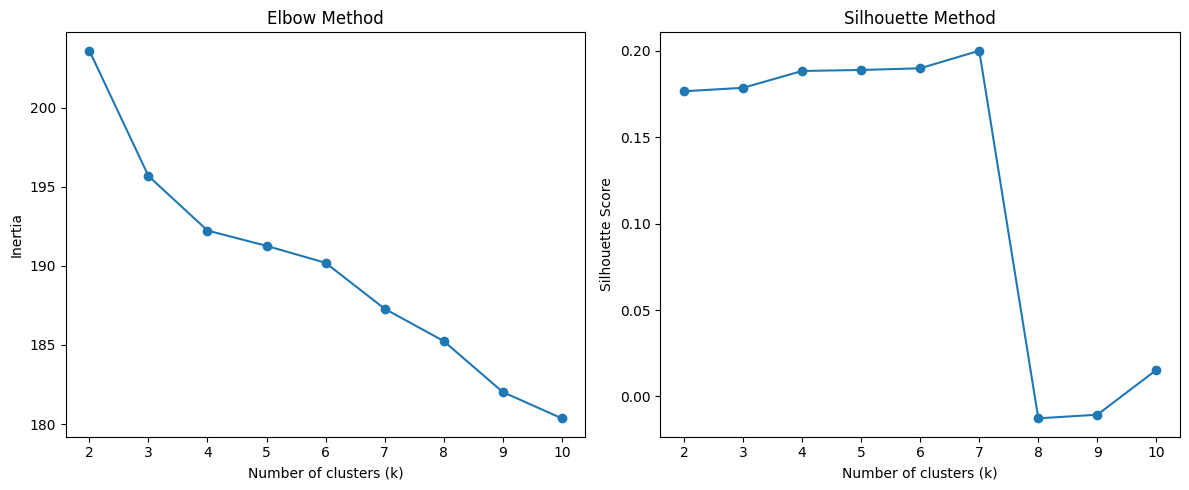

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Store scores
inertia = []
silhouette = []
K = range(2, 11)  # Trying k=2 to k=10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_train)

    inertia.append(kmeans.inertia_)  # Sum of squared distances (Elbow method)
    silhouette.append(silhouette_score(X_train, kmeans.labels_))  # Silhouette score

# Plot inertia (Elbow method)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

plt.tight_layout()
plt.show()


A7

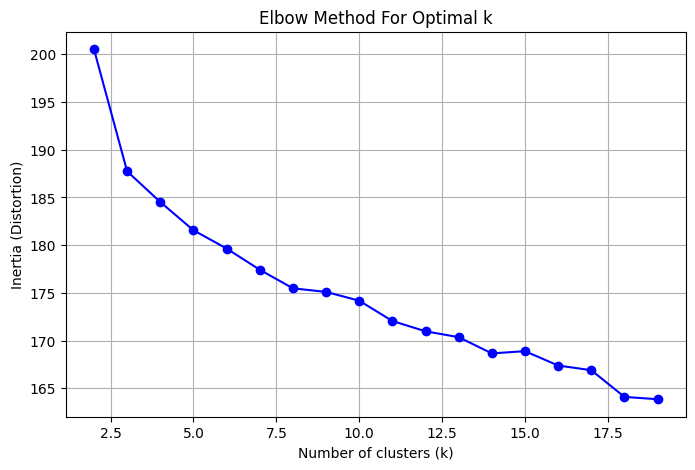

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(2, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_train_features)
    distortions.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()
